The following notebook shows the experimentations performed using optuna

### Importing Necessary Libraries

In [2]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras import regularizers
from tensorflow.keras.regularizers import l2
from tqdm import tqdm

import optuna
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings

import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Suppress TensorFlow INFO and WARNING messages

In [9]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

### 1. Preprocessing - Denoising the signal
This function denoise uses wavelet transform to remove noise from the input signal data. It applies a symmetric 4 (sym4) wavelet and performs a multi-level discrete wavelet decomposition to break the signal into approximation and detail coefficients. The function then thresholds the detail coefficients to filter out noise based on a predefined threshold. Finally, it reconstructs the signal by applying the inverse wavelet transform, returning a cleaner version of the input data.

In [10]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


### 2. Preprocessing – Reading Raw ECG Signals for 48 contiguous ECG excerpts

| **Label** | **Description**                                                                                                                                           |
|-----------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| **N**     | Normal heartbeat or cardiac complex. The electrical activity of the heart is within the normal range, with no abnormalities or irregularities in the heart rhythm. |
| **L**     | Left bundle branch block. An abnormality in the electrical conduction system where signals do not travel normally through the left bundle branch, affecting ventricular contractions. |
| **R**     | Right bundle branch block. An abnormality in the electrical conduction system involving the right bundle branch, similar to left bundle branch block.      |
| **A**     | Atrial premature beat. An early contraction originating in the atria (upper chambers of the heart) before the next expected normal heartbeat.              |
| **V**     | Ventricular premature beat. An early contraction originating in the ventricles (lower chambers of the heart) before the next expected normal heartbeat.     |


In [11]:
path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [12]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

### 3. Preprocessing - Segmentation into windows of 2000 sample points

In [13]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

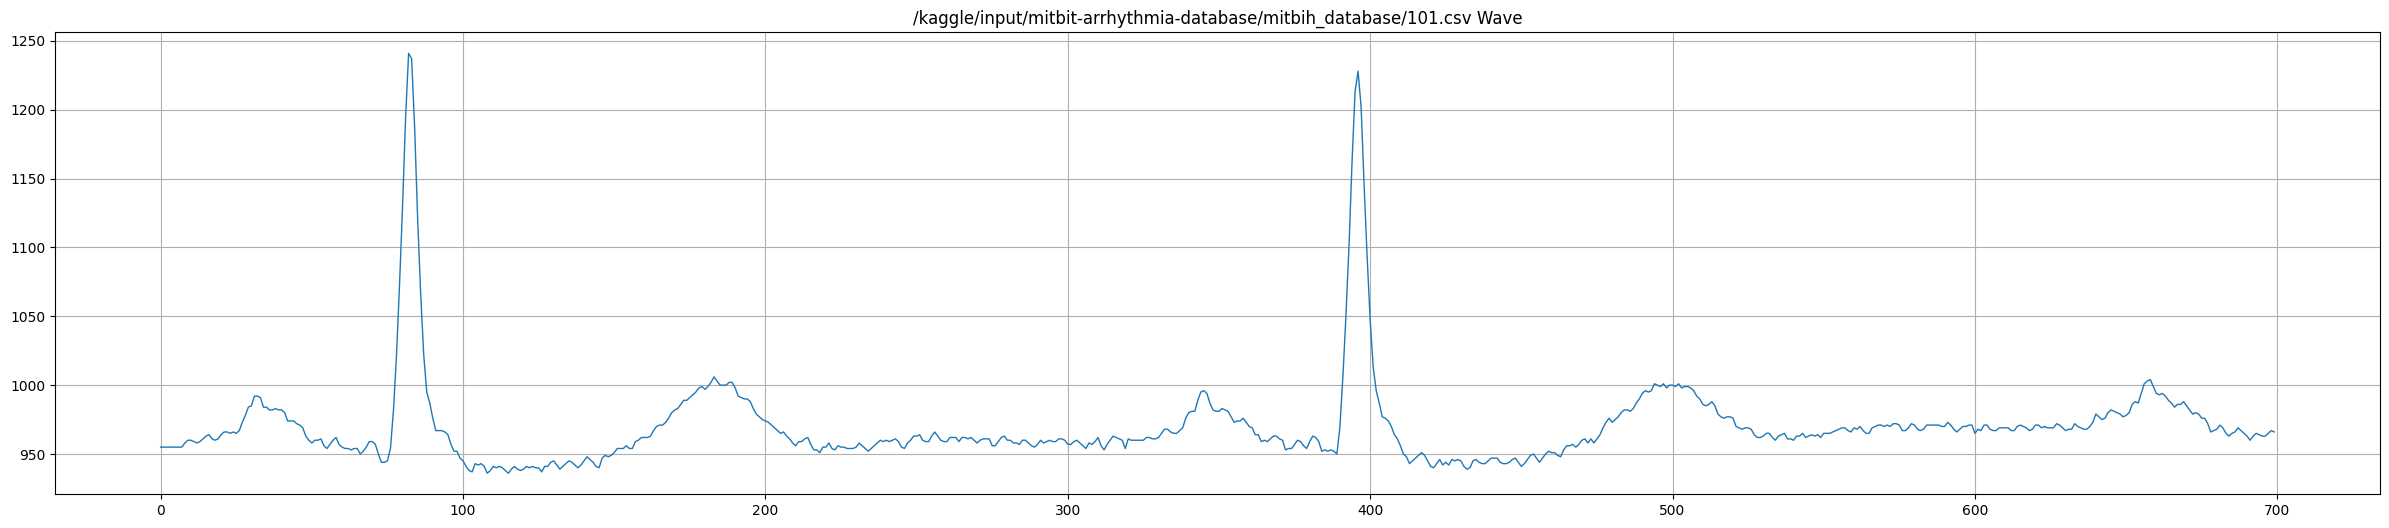

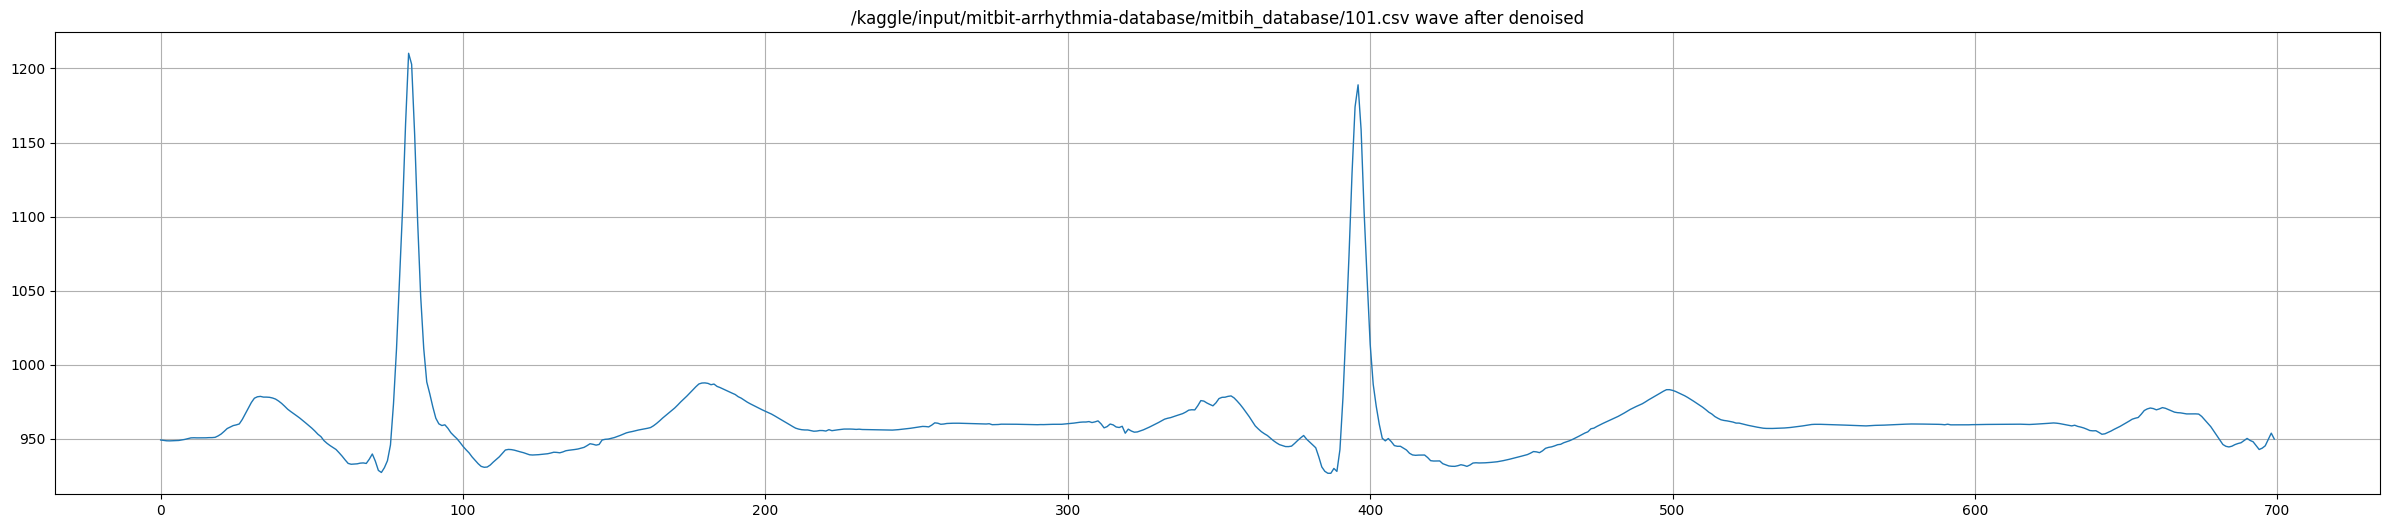

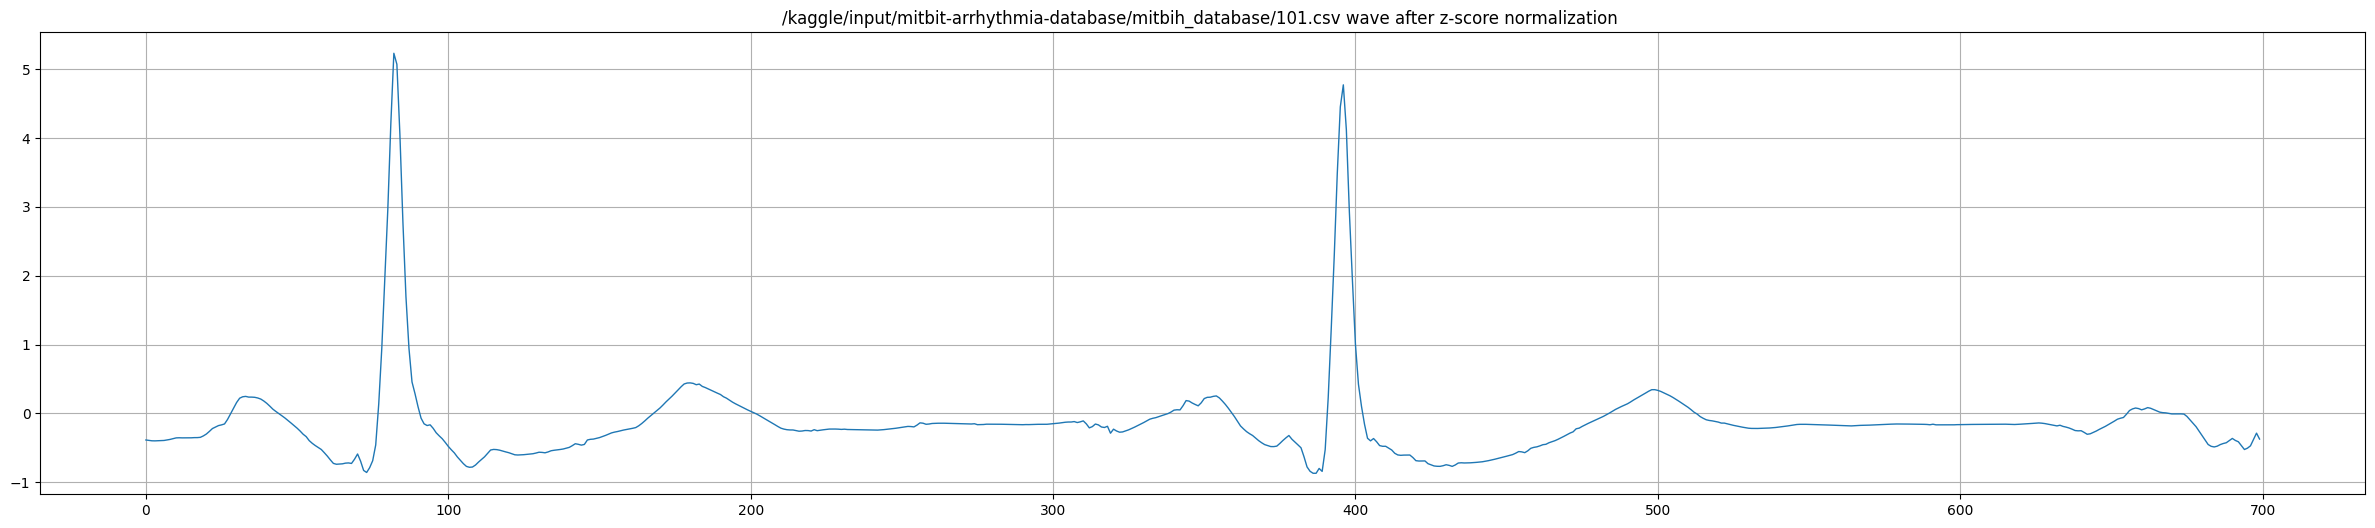

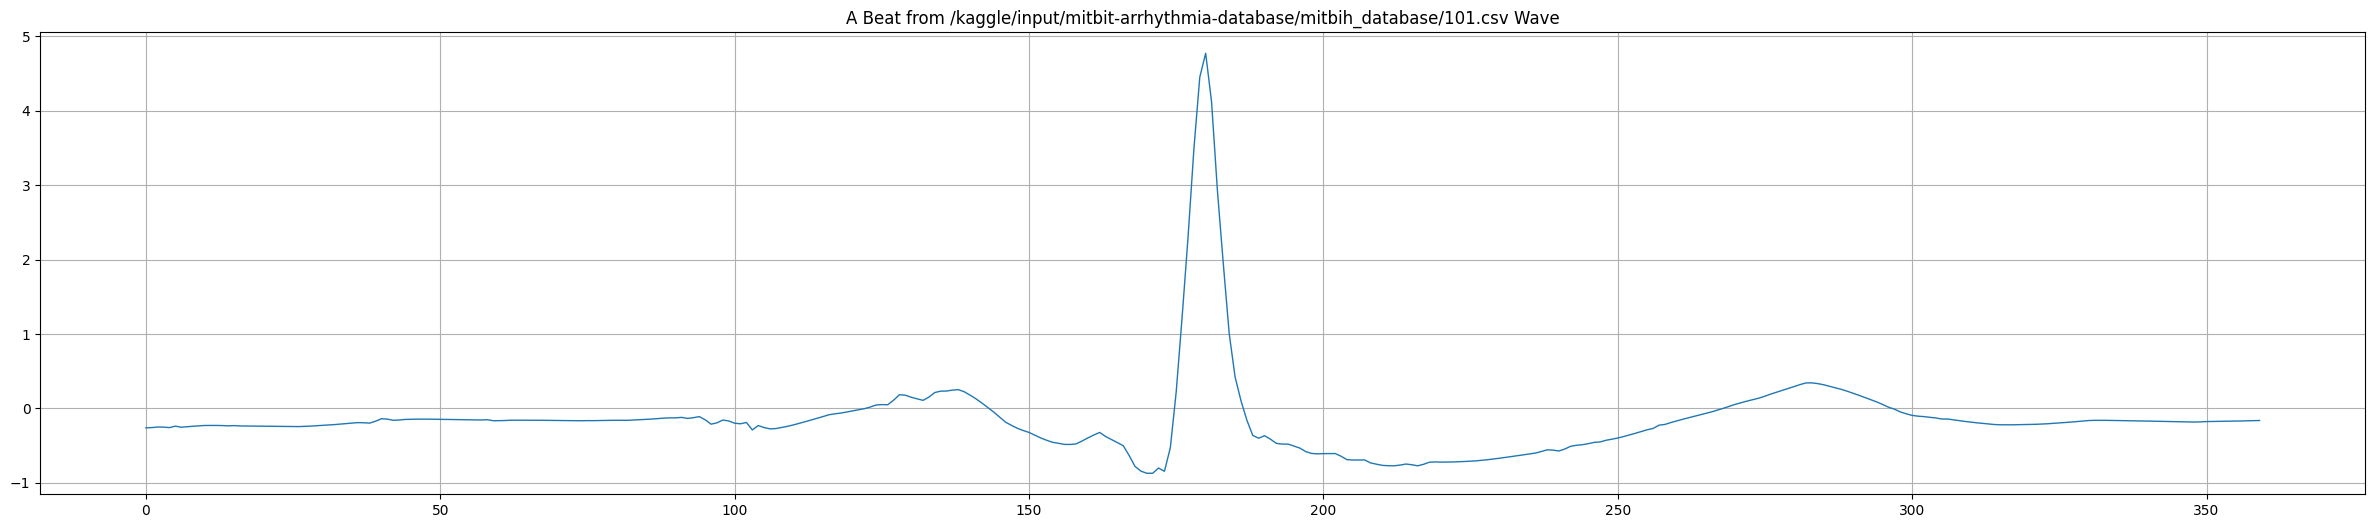

(100012, 360) (100012,)


In [14]:
# Records
for r in range(0, len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')  # read CSV file
        row_index = -1
        for row in spamreader:
            if row_index >= 0:
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example of the signals
    if r == 1:  # Use == for value comparison
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example of the signals
    if r == 1:  # Use == for value comparison
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example of the signals
    if r == 1:  # Use == for value comparison
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read annotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)):  # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted)  # Time... Clipping
            pos = int(next(splitted))  # Sample ID
            arrhythmia_type = next(splitted)  # Type
            if arrhythmia_type in classes:
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if window_size <= pos < (len(signals) - window_size):
                    beat = signals[pos - window_size:pos + window_size]  # REPLACE WITH R-PEAK DETECTION
                    # Plot an example of a beat    
                    if r == 1 and not example_beat_printed:  # Use == for value comparison
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# Data shape
print(np.shape(X), np.shape(y))

In [15]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


### 4. Preprocessing - Balancing the classes with each class having 3000 segments

360
0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: count, dtype: int64


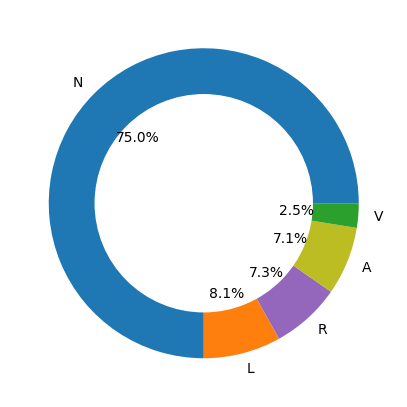

In [17]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(5,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [18]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]

df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=3000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=3000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=3000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=3000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=3000,random_state=125)

X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

360
0.0    3000
1.0    3000
2.0    3000
3.0    3000
4.0    3000
Name: count, dtype: int64


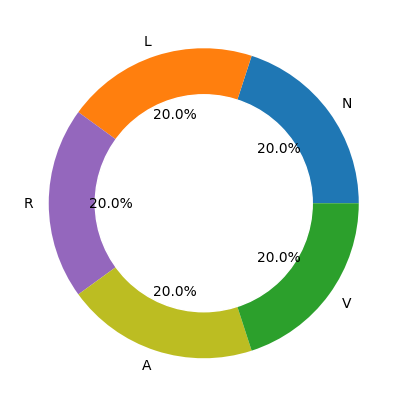

In [19]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(5,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### 5. Performing Train-Test Split before Training the model

In [20]:
# Split the original dataset into train and test sets
train, test = train_test_split(X_train_df, test_size=0.20, random_state=42)

# Further split the training set into train and validation sets
train, val = train_test_split(train, test_size=0.25, random_state=42)  # 25% of the training set

In [21]:
# Prepare the target and features for training, validation, and test sets
target_train = train[train.shape[1]-1]
target_val = val[val.shape[1]-1]
target_test = test[test.shape[1]-1]

train_y = to_categorical(target_train)
val_y = to_categorical(target_val)
test_y = to_categorical(target_test)

In [22]:
train_x = train.iloc[:, :train.shape[1]-1].values
val_x = val.iloc[:, :val.shape[1]-1].values
test_x = test.iloc[:, :test.shape[1]-1].values

train_x = train_x.reshape(len(train_x), train_x.shape[1], 1)
val_x = val_x.reshape(len(val_x), val_x.shape[1], 1)
test_x = test_x.reshape(len(test_x), test_x.shape[1], 1)

In [23]:
print("Training set:", train_x.shape, train_y.shape)
print("Validation set:", val_x.shape, val_y.shape)
print("Test set:", test_x.shape, test_y.shape)

Training set: (9000, 360, 1) (9000, 5)
Validation set: (3000, 360, 1) (3000, 5)
Test set: (3000, 360, 1) (3000, 5)


### 6. Experiment 1 setup where all key hyperparameters are optimized using optuna

In [ ]:

# def objective(trial):
#     # Hyperparameter suggestions
#     num_layers = trial.suggest_int('num_layers', 1, 3)  # Number of Conv1D layers
#     num_filters = [trial.suggest_int(f'num_filters_{i}', 16, 128, step=16) for i in range(num_layers)]
#     kernel_sizes = [trial.suggest_int(f'kernel_size_{i}', 3, 15, step=2) for i in range(num_layers)]
#     dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
#     batch_size = trial.suggest_int('batch_size', 32, 128, step=32)
#     learning_rate = trial.suggest_float('learn_rate', 1e-5, 1e-1, log=True)


#     # Build the model
#     model = Sequential()
#     input_shape = train_x.shape[1:]  # Input shape
#     for i in range(num_layers):
#         if i == 0:
#             model.add(Conv1D(filters=num_filters[i], kernel_size=kernel_sizes[i], padding='same', activation='relu', input_shape=input_shape))
#         else:
#             model.add(Conv1D(filters=num_filters[i], kernel_size=kernel_sizes[i], padding='same', activation='relu'))
#         model.add(AvgPool1D(pool_size=2))  # Add pooling after each Conv1D layer

#     model.add(Flatten())
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
#     model.add(Dense(5, activation='softmax', kernel_regularizer=l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))

#     # Compile the model
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#     # Train the model
#     history = model.fit(train_x, train_y, batch_size=batch_size, epochs=num_epochs, verbose=0, validation_data=(val_x, val_y))

#     # Evaluate on the validation set
#     val_loss, val_accuracy = model.evaluate(val_x, val_y, verbose=0)
#     return val_accuracy

### 6. Experiment 2 setup where certain hyperparameters like batch size, number of epochs and learning rate are fixed, while all other hyperparameters are optimized using optuna

In [24]:
def objective(trial):
    # Hyperparameter suggestions
    num_layers = trial.suggest_int('num_layers', 1, 3)  # Number of Conv1D layers
    num_filters = [trial.suggest_int(f'num_filters_{i}', 16, 128, step=16) for i in range(num_layers)]
    kernel_sizes = [trial.suggest_int(f'kernel_size_{i}', 3, 15, step=2) for i in range(num_layers)]
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    batch_size = 36
    num_epochs = 60

    # Build the model
    model = Sequential()
    input_shape = train_x.shape[1:]  # Input shape
    for i in range(num_layers):
        if i == 0:
            model.add(Conv1D(filters=num_filters[i], kernel_size=kernel_sizes[i], padding='same', activation='relu', input_shape=input_shape))
        else:
            model.add(Conv1D(filters=num_filters[i], kernel_size=kernel_sizes[i], padding='same', activation='relu'))
        model.add(AvgPool1D(pool_size=2))  # Add pooling after each Conv1D layer

    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(5, activation='softmax', kernel_regularizer=l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))

    optimizer = Adam()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_x, train_y, batch_size=batch_size, epochs=num_epochs, verbose=0, validation_data=(val_x, val_y))

    # Evaluate on the validation set
    val_loss, val_accuracy = model.evaluate(val_x, val_y, verbose=0)
    return val_accuracy

In [25]:
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)


#### Checking if TPU is available for running optuna

In [26]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Automatically detects TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU")
except ValueError:
    print("No TPU found. Please check your environment.")

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1732501780.808821  327274 service.cc:145] XLA service 0x5c4435be5390 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732501780.808899  327274 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1732501780.808903  327274 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1732501780.808906  327274 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1732501780.808909  327274 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1732501780.808912  327274 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1732501780.808914  327274 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1732501780.808917  327274 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1732501780.808920  327274 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

### 8. Running Optuna

In [27]:
with strategy.scope():
    study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler())
    study.optimize(objective, n_trials=20)

[I 2024-11-25 02:29:50,023] A new study created in memory with name: no-name-b6e24cf7-0d7e-4ac1-bb25-5d79ac95075a
/tmp/ipykernel_327274/3652726430.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
/usr/local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1732501790.099037  327274 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-11-25 02:29:54.289092: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model

### 9. Best Trial Obtained for Experiment 2

In [28]:
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  0.9679999947547913
  Params: 
    num_layers: 3
    num_filters_0: 64
    num_filters_1: 64
    num_filters_2: 96
    kernel_size_0: 9
    kernel_size_1: 3
    kernel_size_2: 7
    dropout_rate: 0.20368709608876687
